In [1]:
import numpy as np

# From Assignment
eta = 1
omega_K = 0.05 * 2 * np.pi      # From table 0.05 Hz -> [rad/s]
omega_k = 0.06 * 2 * np.pi      # From table 0.05 Hz -> [rad/s]
zeta = 0.70                     # From table 70%

# From HAWC2S
I = 0.182099E+09                         # From HAWC2 results:   I = (I_r + ng**2 * Ig )
dQ_dTheta = -1095.95589e3 * 180/np.pi   # From HAWC2S: [Nm/deg] -> [Nm/rad]
dQ_dOMEGA = 0                            # From slides



# Values for our wind turbine
p_r = 10.638e6                      # Rated power [Watt]
omega_r = 9.04 / 60 * 2 *  np.pi   # Omega rated [RPM] -> [rad/s]
dQ_g_dOMEGA = -p_r/omega_r**2

# Torque controller: $K_{Pg}$ [Nm/(rad/s)] & $K_{Ig}$ [Nm/rad] 

In [2]:
K_Pg = eta * (2*I*omega_K*zeta + dQ_dOMEGA)
K_Ig = eta * I * omega_K**2

print(f'K_Pg = {K_Pg}')
print(f'K_Ig = {K_Ig}')

K_Pg = 80091323.28764667
K_Ig = 17972450.91833971


# Pitch controller: $k_P$ [rad/(rad/s)] & $k_I$ [rad/rad] (WRONG VALUES??)

In [3]:
k_P = (2*zeta*omega_k*I + dQ_dOMEGA - 1/eta * dQ_g_dOMEGA) / (-dQ_dTheta)
k_I = omega_k**2 * I / (-dQ_dTheta)

print(f'k_P = {k_P}')
print(f'k_I = {k_I}')

k_P = 1.7196007508037605
k_I = 0.41214884859688405


# FIT

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
from lacbox.io import load_ctrl_txt
from lacbox.test import test_data_path
import pandas as pd

fname = '../res_hawc2s/BB_neo_contrltune_ref_ctrl_tuning.txt'

ctrltune_dict = load_ctrl_txt(fname)

aero_gains_df = ctrltune_dict['aero_gains']


column_1 = aero_gains_df['dq/dtheta_kNm/deg'].keys()
column_2 = aero_gains_df['dq/dtheta_kNm/deg'].values

# Perform quadratic polynomial fit (degree 2)
coefficients = np.polyfit(column_1, column_2, 2)


# f(theta) = A + B*theta + C*theta**2
# A = dq/dtheta, B = dq/dtheta / KK1, C = dq/dtheta / KK2

C = coefficients[0]
B = coefficients[1]
A = coefficients[2]

KK1 = A/B
KK2 = A/C

print(KK1, KK2)





12.162089618774955 398.42904283460376


# Plots

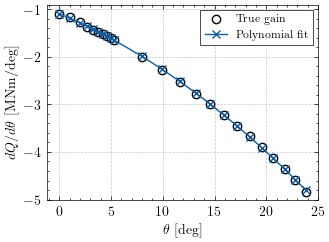

In [6]:
import matplotlib.pyplot as plt
import scienceplots
# matplotlib.rcParams.update(matplotlib.rcParamsDefault) # TO RESET  PLOTS
plt.style.use('science')

# # Set global font properties
plt.rcParams['legend.frameon'] = True  # Enable the legend frame
plt.rcParams['legend.fancybox'] = False  # No fancybox, just a regular box
plt.rcParams['legend.edgecolor'] = 'black'  # Black edge color
plt.rcParams['legend.framealpha'] = 1  # No transparency
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'normal'


figure = plt.plot(figsize=(4, 3))
plt.plot(aero_gains_df['dq/dtheta_kNm/deg']/1000, c='k', marker='o',
            linestyle='none', mfc='none', label='True gain')
plt.plot(aero_gains_df['fit_kNm/deg']/1000, c='C0', marker='x', label='Polynomial fit')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel(r'$dQ/d \theta$ [MNm/deg]')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
legend = plt.legend(fancybox=False, edgecolor="black", fontsize=8)
legend.get_frame().set_linewidth(0.5)    
plt.tight_layout()
plt.savefig('part_1_theoretical_fitting_BB_neo.pdf', dpi = 300, bbox_inches='tight')